<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL Advanced Analytics in Business [D0S07a]: Group Assignment 2 - Deep Learning on Images
---------------------------------------------------------------




# 1. Introduction

The goal of the second assignment is to detect swimming pools using satellite images. More specifically, we chose to construct a deep learning model that located the swimming pool in images that contained one using a bounding box. The dataset we received contained more than 14.000 images each containing a swimming pool. In addition to the images, we also received a json-file with coordinates for the bounding boxes as well as the coordinates of the location. The entire dataset contained 14964 images. During the first couple of tries of training the model using the entire dataset, we noticed two problems. Firstly, some of the laptops used were not able to handle the workload and kept crashing. Secondly, it took a very long time to train the model using the entire dataset. For these reasons we opted to take a subset of the dataset to train our model. By taking a subset we were able to successfully build a model as well as building the model quicker. For our model we used X numbers of images.

The process for this assignment is as follows. The first step is to extract the data needed for this project. As mentioned before, we received a json file with the coordinates however we only needed the X and Y coordinates and not the longitude and latitude. The second step, we need to do a bit of pre-processing before training the model. The main thing is this step was to resize the image to 512 pixels. The third step is to build the model. Lastly, we will evaluate the model. 

## 1.1 Libraries


For the assignment the following libraries were used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import json
from matplotlib.patches import Rectangle

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

## 1.2 Data


In [2]:
PATH = ''
NUMBER_TO_LOAD = 500  # for whole dataset, use 14964 
MUTE = True
IMG_SIZE = (128,128)
INPUT_SHAPE = (128,128,3)

In [3]:
with open(PATH + 'metadata.json') as f:
    y_dict = json.load(f)

#### The first thing we do is to check if all the images actually have a pool. 


In [4]:
count = 0
for i in y_dict.keys():
    if y_dict[i]['has_pool'] == False:
        count += 1

if count == 0:
    print("All images have swimming pools!")

All images have swimming pools!


#### Check if there's any name in .json cannot link to a .png image. Then save valid .png names into a list.

In [5]:
png_name = []
for i in list(y_dict.keys())[:NUMBER_TO_LOAD]:
    try:
        img = plt.imread(PATH+'images/'+i)
    except:
        if MUTE:
            pass
        else:
            print(f"cannot find the image {i}")
    else:
        png_name.append(i)
print(f"{len(png_name)} images are valid out of {NUMBER_TO_LOAD}!")

448 images are valid out of 500!


#### Split image names into train, validation and test set
It would be memory-saving to do train test split only on file names, and load images when using them. ***1st memory control approach***

In [6]:
X_train, X_test = train_test_split(png_name, test_size=0.2)
X_train, X_val = train_test_split(X_train, test_size=0.25)

## 1.3 Image loading and preprocessing
Here we'd like to load and process the image, and then do some visulizations to compare bounding-box created and original polygon boundaries.

#### Functions for loading and processing images 
Here we create an one-step function to provide data for visualization as well as the model by the followings:
- Read and resize the image. Resizing into a small trainable size before saving is the ***2nd memory control approach***
- Extract and compute the optimal rectangle from the polygon boundaries. We apply boundingRect from opencv to find the bounding rectangle.
- For plotting, it will return a dataframe with both images and unscaled labels, while for modelling, it will return images with labels scaled into [0,1].


In [7]:
# TRY cv2.minAreaRect from https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html  7.b
def load_resize_img(y_dict, png_list, path=PATH, image_size=IMG_SIZE, plot=False): 
    '''
    to plot: image_size=(512,512), plot=True
    to train: image_size=(IMG_SIZE), plot=False
    '''
    
    image = []
    label = []

    for i in png_list:
        img = plt.imread(PATH+'images/'+i)

        image.append(cv2.resize(img,image_size))

        coord = np.array([[j['x'],j['y']] for j in y_dict[i]['bounds_x_y']], np.float32) 
        x,y,w,h = cv2.boundingRect(coord)
        label.append([x, y, x+w, y+h])
    
    if plot:
        return pd.DataFrame({'png_name':png_list, 'image':image, 'label':label})
    else:
        df = pd.DataFrame({'image':image, 'label':label})
        del image, label
        X = np.stack([row['image'] for index, row in df.iterrows()])
        y = np.stack([list(map(lambda x: x/512, row['label'])) for index, row in df.iterrows()])
        dflist = [df]
        del df, dflist

        return X, y
    

#### Comparisons of polygon and rectangular labels
Using the the function we just created, we take a first look at the images with the bounding boxes. The blue Polygons are the ones created using the coordinates in the json file. The red bounding boxes are the ones detected by opencv.

In [8]:
def plot_img(df, n_to_plot=10):  
    df_plot = df.loc[:n_to_plot, :]

    fig, axs = plt.subplots(1, n_to_plot, figsize=(80, 80* n_to_plot))

    for i in range(n_to_plot):
        axs[i].imshow(df_plot.iloc[i,1])
        xs, ys = zip(*[(i['x'], i['y']) for i in y_dict[df_plot.iloc[i,0]]['bounds_x_y']])
        axs[i].plot(xs, ys, linewidth=5)
        x1, y1, x2, y2 = df_plot.iloc[i,2]
        axs[i].add_patch(Rectangle((x1,y1),x2-x1,y2-y1,linewidth=5,edgecolor='r',facecolor='none'))
        axs[i].axis("off")

    plt.show()

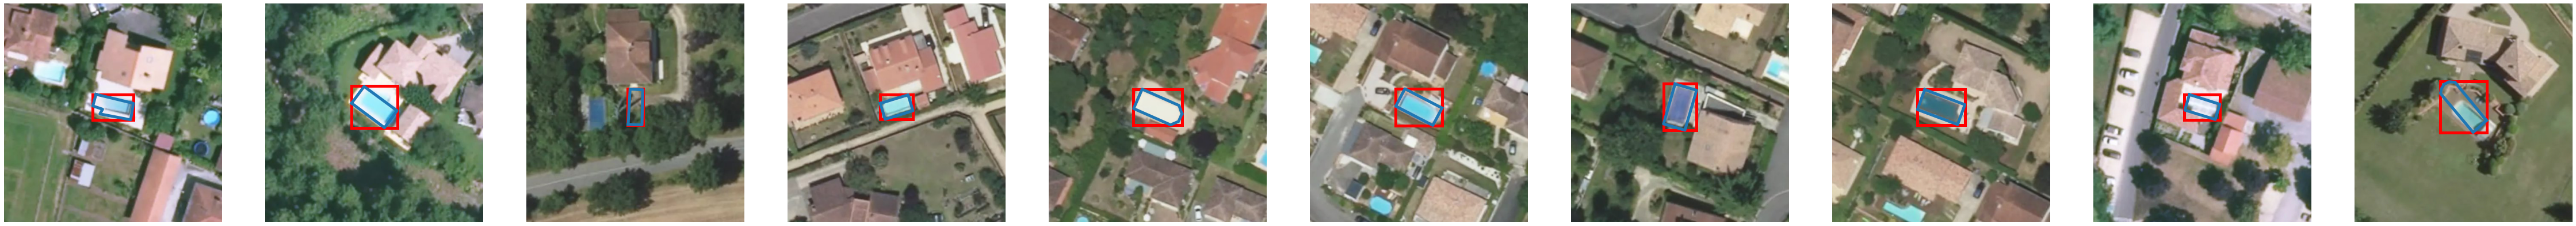

In [9]:
df = load_resize_img(y_dict, X_train, path=PATH, image_size=(512,512), plot=True)
plot_img(df, n_to_plot = 10) 

dflist = [df]
del df, dflist

# 2. Model Building


#### function of images and labels for the model 


Given the dataset for training is still time and resource demanding, inspired by [this link](https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/), we tend to use VGG16 with weights pre-trained on ImageNet as our model. VGG16 is a convolution neural network which is considered to be one of the excellent vision model architecture till date. It follows an arrangement of convolution and max pool layers consistently throughout the whole architecture. The image below shows a visual representation of the VGG16 model. 

Meaningful initial weights can speed up the training process with less epochs. We also define a method to plot images with the top n good and top n bad performance. 

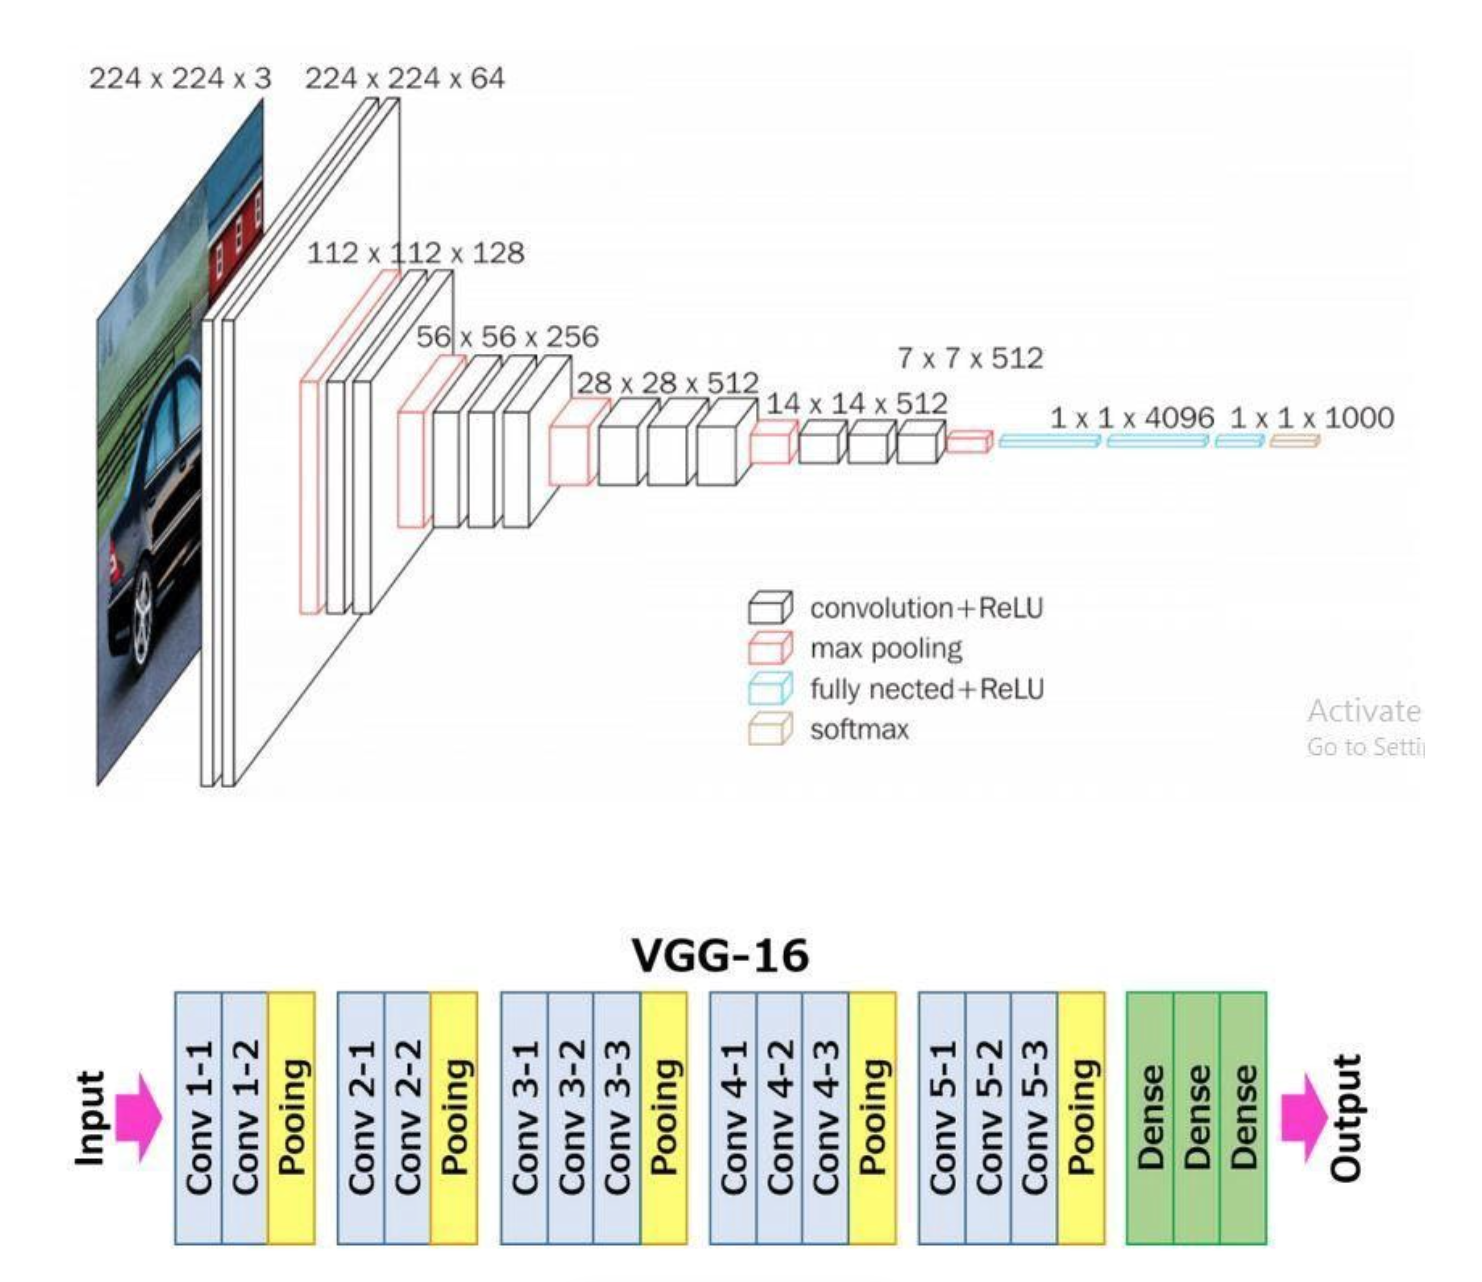

#### class of the model


In [10]:
class VGG_detection():
    '''
    https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
    '''
    def __init__(self, params, verbose=False):
        self.params = params
        self.verbose = verbose
     
    
    def get_vgg(self):
        input_shape = self.params['input_shape']   # (img_height, img_width, img_channels)
        weights = self.params['weights']
        include_top = self.params['include_top']
        vgg = VGG16(
            weights=weights,    # None if random initialization
            include_top=include_top,
            input_tensor=Input(shape=input_shape))
        
        vgg.trainable = False       # freeze all VGG layers so they will *not* be updated during the training process
        flatten = vgg.output        # flatten the max-pooling output of VGG
        flatten = Flatten()(flatten)
        x = Dense(128, activation="relu")(flatten)   # construct a fully-connected layer header to output the predicted bounding box coordinates
        x = Dense(64, activation="relu")(x)
        x = Dense(32, activation="relu")(x)
        x = Dense(4, activation="sigmoid")(x)
        
        self.model = Model(inputs=vgg.input, outputs=x)
        return self
    
    
    def fit_vgg(self, X_train, X_val, y_train, y_val):
        optimizer = self.params['optimizer']
        loss = self.params['loss']
        metrics = self.params['metrics']
        batch_size = self.params['batch_size']
        epochs = self.params['epochs']
        verbose = self.verbose
        save_name = self.params['save_name']
        monitor = self.params['monitor']
        
        self.model.compile(loss=loss, optimizer=optimizer, metrics=[eval(metrics)])
        earlystop = EarlyStopping(monitor=monitor, patience=5)
        
        self.history = self.model.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=verbose,
                                      callbacks = [earlystop])
        
        if save_name:
            self.model.save(save_name)
            np.save('history_' + save_name +'.npy', self.history.history)

            
    def learning_curves(self):
        history = self.history
        epoches = len(history.history["loss"])
        mse = history.history["mean_squared_error"]
        val_mse = history.history["val_mean_squared_error"]

        loss = history.history["loss"]
        val_loss = history.history["val_loss"]

        epochs_range = range(epoches)

        fig = plt.figure(figsize=(12,6))

        plt.subplot(1,2,1)
        plt.plot(epochs_range, mse, label="train mse")
        plt.plot(epochs_range, val_mse, label="validataion mse")
        plt.title("mse")
        plt.xlabel("Epoch")
        plt.ylabel("mse")
        plt.legend(loc="lower right")

        plt.subplot(1,2,2)
        plt.plot(epochs_range, loss, label="train loss")
        plt.plot(epochs_range, val_loss, label="validataion loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")

        fig.tight_layout()
        plt.show()    
    
    
    def predict(self, X_test):
        load_name = self.params['load_name']
        if load_name:
            m_loaded = load_model("./"+load_name) 
            pred_test = m_loaded.predict(X_test)
        else: 
            pred_test = self.model.predict(X_test)
        
        return pred_test
    
    
    def show_result(self, pl, img_train, y_train, y_pred, best=True):
        input_shape = self.params['input_shape']
        each_loss = [MeanSquaredError()(y_train[i], y_pred[i]).numpy() for i in range(y_pred.shape[0])]
        if best:
            index = np.argsort(each_loss)
        else:
            index = np.argsort(each_loss)[::-1]
        
        fig, axs= plt.subplots(1, pl, figsize = (80, 80*pl))
        for i in range(pl):
            axs[i].imshow(img_train[index[i]])
            x1, y1, x2, y2 = y_train[index[i]]*input_shape[0]
            axs[i].add_patch(Rectangle((x1,y1),x2-x1,y2-y1,linewidth=5,edgecolor='b',facecolor='none'))
            x1, y1, x2, y2 = y_pred[index[i]]*input_shape[0]
            axs[i].add_patch(Rectangle((x1,y1),x2-x1,y2-y1,linewidth=5,edgecolor='r',facecolor='none'))
            axs[i].axis("off")
    
        plt.show()
    

# 3. Model Evaluation

#### Ingredients for training
Define the params of the vgg model class. Specifing "imagenet" for 'weights' of the vgg model is the ***3rd memory control approach***


In [11]:
params = {# params for vgg
          'input_shape':INPUT_SHAPE,
          'weights':"imagenet",
          'include_top':False,
  
          # params for model compile
          'optimizer':"adam",
          'loss': "mse", #   
          'metrics':"MeanSquaredError()",
          'monitor':"mean_squared_error",
            
          'save_name':False,  # if no need to save, fill in 'False'
          'batch_size':4,
          'epochs':20,
    
          # for predict
          'load_name':False   # if no need to load, fill in 'False'
}

Load the images for training and validation with fuction load_resize_img.

In [12]:
X_train, y_train = load_resize_img(y_dict, X_train, path=PATH, image_size=IMG_SIZE, plot=False)
X_val, y_val = load_resize_img(y_dict, X_val, path=PATH, image_size=IMG_SIZE, plot=False)

Since the task here is in regression flavour, we use mean squared error as our main metrics.

2022-05-29 15:11:43.540580: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
67/67 [==============================] - 26s 376ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/20
67/67 [==============================] - 26s 394ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.1063e-04 - val_mean_squared_error: 8.1063e-04
Epoch 3/20
67/67 [==============================] - 25s 377ms/step - loss: 7.7887e-04 - mean_squared_error: 7.7887e-04 - val_loss: 8.0063e-04 - val_mean_squared_error: 8.0063e-04
Epoch 4/20
67/67 [==============================] - 27s 404ms/step - loss: 4.4421e-04 - mean_squared_error: 4.4421e-04 - val_loss: 6.9520e-04 - val_mean_squared_error: 6.9520e-04
Epoch 5/20
67/67 [==============================] - 24s 353ms/step - loss: 2.1856e-04 - mean_squared_error: 2.1856e-04 - val_loss: 6.9180e-04 - val_mean_squared_error: 6.9180e-04
Epoch 6/20
67/67 [==============================] - 24s 365ms/step - loss: 1.4401e-04 - mean_squared_error: 1.4401e-04 - val_loss

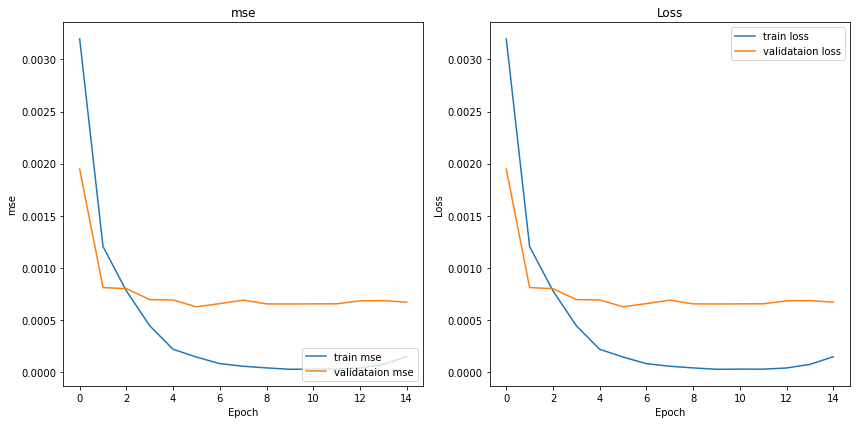

In [13]:
vgg = VGG_detection(params, MUTE).get_vgg()
vgg.fit_vgg(X_train, X_val, y_train, y_val)
vgg.learning_curves()

# 4. Prediction

In this section, we predict bounding box on test images and show the top 5 best and worst images with predicted box (in red) and true box (in blue).

In [14]:
l_xtrain = [X_train]
l_ytrain = [y_train]
l_xval = [X_val]
l_yval = [y_val]
del X_train, y_train, X_val, y_val
del l_xtrain, l_ytrain, l_xval, l_yval

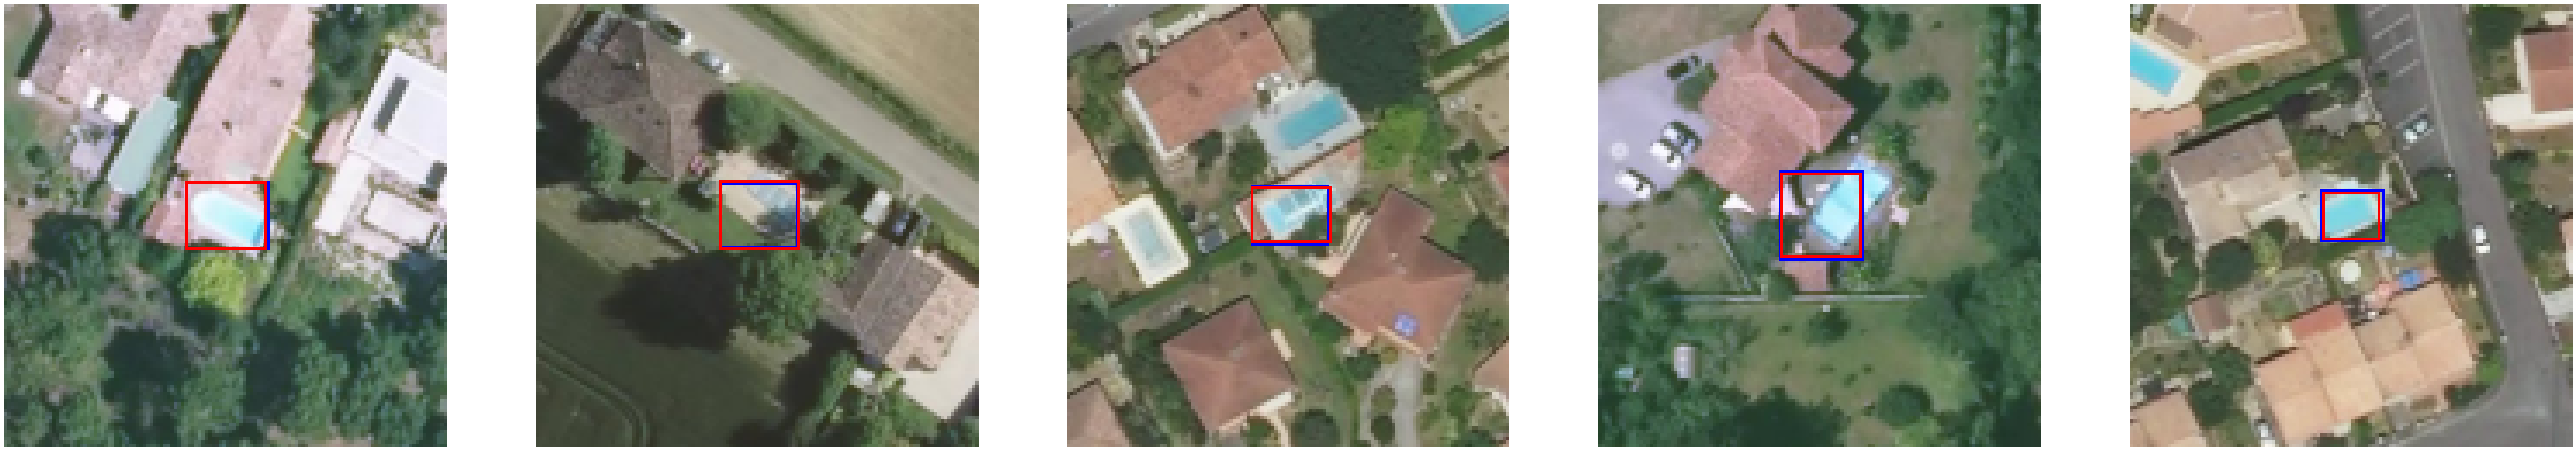

In [15]:
X_test, y_test = load_resize_img(y_dict, X_test, path=PATH, image_size=IMG_SIZE, plot=False)
y_pred = vgg.predict(X_test)
vgg.show_result(5, X_test, y_test, y_pred, best=True)

The blue polygons are the original boundaries while the red bounding boxes are the bounding boxes we predicted using our model. We see that overall our model was able to predict the location of the swimming pools. The best predictions are almost identical to the true boundaries, while for the worst ones, predicted bounding boxes are far from their true targets. Because some pools don't have a clear color, which makes the model difficult to differentiate them from the surroundings (from the 1st 3rd and 4th worst predictions below). 


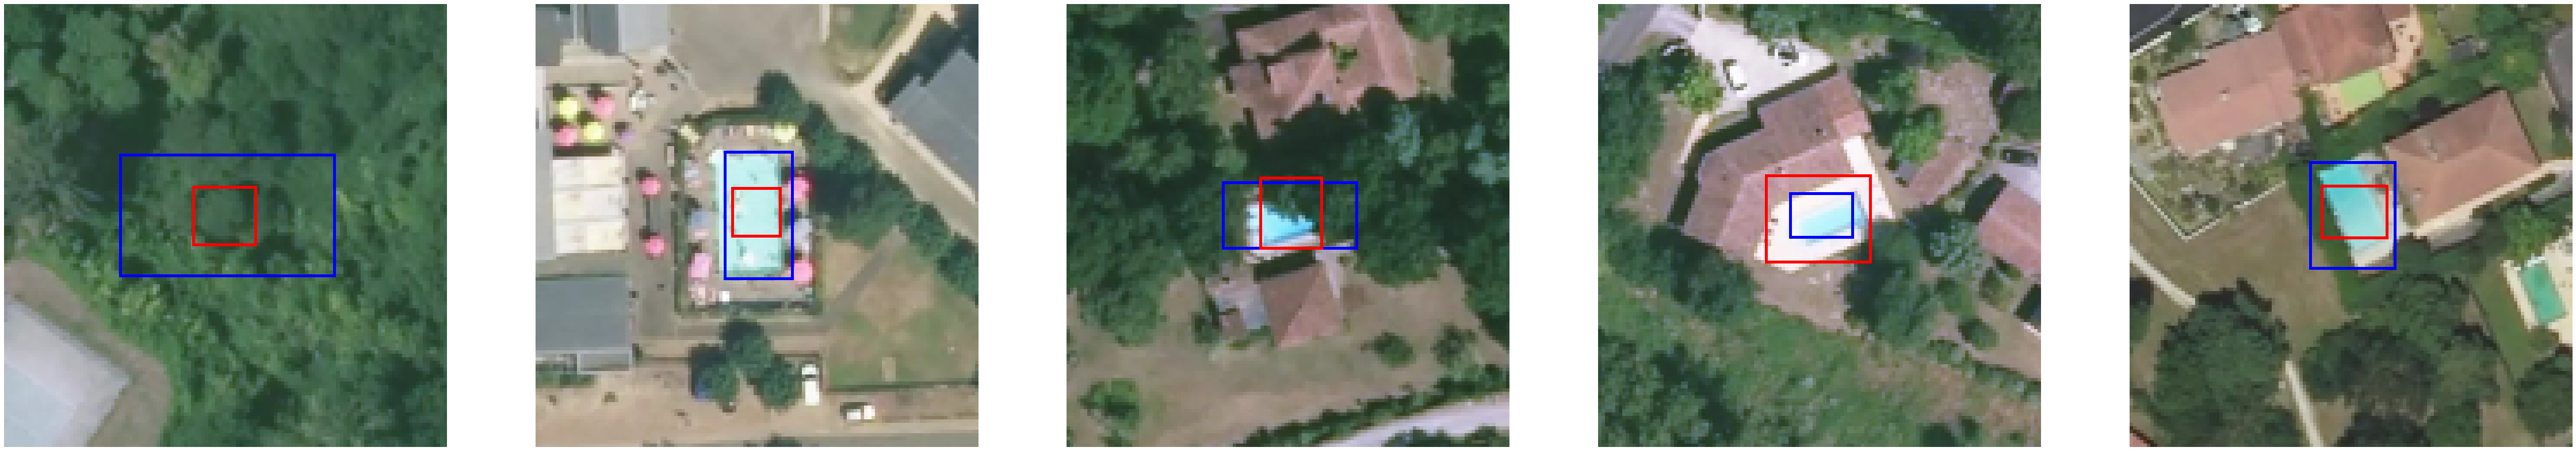

In [16]:
vgg.show_result(5, X_test, y_test, y_pred, best=False)

The last code shows a summary of the model.

In [17]:
vgg.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     